In [15]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split


In [16]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
!pip install opencv-python
!pip install torch
!pip install torchvision
# !pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.1 MB/s eta 0:00:00a 0:00:01


In [17]:
import numpy as np
import pandas as pd
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

class myLabeling:
    """ 特定の値以外はすべて0にする。
        Args:
        2d_numarray (<class 'numpy.ndarray'>): 2次元配列の画像データ
        value: フィルターする値
    """
    @staticmethod
    def filter(src, value):
        copied = src.copy();
        return np.where(copied != value, 0, value)

    """ maskに値が入っている場所の値のみをsrcから取得
    """
    @staticmethod
    def mask(src, mask):
        copied = mask.copy()
        for y in range(len(copied)):
            for x in range(len(copied[0])):
                if mask[y][x] != 0:
                    mask[y][x] = src[y][x]
        return copied

    """ maskのうち値が0以外のものsrcの上に上書きする。
    """
    @staticmethod
    def overwrite(src, mask):
        copied = src.copy()
        for y in range(len(copied)):
            for x in range(len(copied[0])):
                if mask[y][x] != 0:
                    copied[y][x] = mask[y][x]
        return copied

    """ 8近傍をチェックして、画像データと最大のラベルと最大のサイズをかえす
    """
    @staticmethod
    def cv_labeling(src):
        import cv2
        copied = src.copy()
        for y in range(len(copied)):
            for x in range(len(copied[0])):
                if copied[y][x] > 1:
                    copied[y][x] = 1
                else:
                    copied[y][x] = 0
        nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(copied)
        max_label = 1
        for label in range(nLabels - 1):
            x, y, w, h, size = data[label + 1]
            if size > data[max_label][4]:
                max_label = label + 1
        x, y, w, h, size = data[max_label]
        return {'labelMap': labelImages, 'max_label': max_label, 'max_label_cnt': size, 'data': data[max_label]}

    def preprocess_detail(image):
        labelObject = myLabeling.cv_labeling(image)
        filtered = myLabeling.filter(labelObject['labelMap'], labelObject['max_label'])
        masked = myLabeling.mask(image, filtered)
        flatted = np.where(image.copy() > 0, 1, 0)
        masked_flat = np.where(masked > 0, 2, 0)
        img = myLabeling.overwrite(flatted, masked_flat)
        labelObject['labelMap'] = img
        return labelObject
        
    def preprocess(image):
        labelObject = myLabeling.cv_labeling(image)
        filtered = myLabeling.filter(labelObject['labelMap'], labelObject['max_label'])
        masked = myLabeling.mask(image, filtered)
        flatted = np.where(image.copy() > 0, 1, 0)
        masked_flat = np.where(masked > 0, 2, 0)
        img = myLabeling.overwrite(flatted, masked_flat)
        # imgに labelObject['labelMap'] や filteredを入れることで、処理の経過を見ることができます。
        return img

    def simple(image):
        labelObject = myLabeling.cv_labeling(image)
        filtered = myLabeling.filter(labelObject['labelMap'], labelObject['max_label'])
        masked = myLabeling.mask(image, filtered)
        # img = myLabeling.overwrite(flatted, masked_flat)
        img = masked
        # imgに labelObject['labelMap'] や filteredを入れることで、処理の経過を見ることができます。
        return img
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def get_x_data(df, is_fit=True, size=1.0):
    target_size = (28, 28)
    resized_images = []
    for img in df['waferMap']:
        resized_img = resize(img, target_size, anti_aliasing=True)
        resized_images.append(resized_img)
        img = myLabeling.preprocess(img)
    _X_data = np.array(resized_images)
    X_data = torch.tensor(_X_data, dtype=torch.float)
    X_data = X_data.unsqueeze(1)
    return X_data

def solution(x_test_df, train_df):
    le = LabelEncoder()
    X_train = get_x_data(train_df)
    y_train = le.fit_transform(np.array(train_df['failureType']))
    X_test = get_x_data(x_test_df, False)

    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    # Normalize data
    normalize = transforms.Normalize(mean=[0.5], std=[0.5])
    X_train = normalize(X_train)
    X_test = normalize(X_test)

    # Create DataLoader with data augmentation
    train_dataset = TensorDataset(X_train, torch.tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    model = Net()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate
    criterion = nn.CrossEntropyLoss()

    epoch = 20  # Increase the number of epochs
    for i in range(1, epoch + 1):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {i}/{epoch}, Loss: {loss.item()}")

    # Move model back to CPU before predicting
    model.to("cpu")
    outputs = model(torch.tensor(X_test, dtype=torch.float))
    _, predicted = torch.max(outputs.data, 1)
    y_pred = le.inverse_transform(predicted.numpy())

    return pd.DataFrame({'failureType': y_pred}, index=x_test_df.index)


In [18]:
# %%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.1, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))

    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

Epoch 1/20, Loss: 0.41666489839553833
Epoch 2/20, Loss: 0.3963647782802582
Epoch 3/20, Loss: 0.28661468625068665
Epoch 4/20, Loss: 0.4385272264480591
Epoch 5/20, Loss: 0.16574887931346893
Epoch 6/20, Loss: 0.1574547439813614
Epoch 7/20, Loss: 0.10016892105340958
Epoch 8/20, Loss: 0.17506127059459686
Epoch 9/20, Loss: 0.08693794906139374
Epoch 10/20, Loss: 0.07306203991174698
Epoch 11/20, Loss: 0.08095819503068924
Epoch 12/20, Loss: 0.06236174330115318
Epoch 13/20, Loss: 0.08293803781270981
Epoch 14/20, Loss: 0.019932573661208153
Epoch 15/20, Loss: 0.037722472101449966
Epoch 16/20, Loss: 0.03898633271455765
Epoch 17/20, Loss: 0.034997548907995224
Epoch 18/20, Loss: 0.0563085563480854
Epoch 19/20, Loss: 0.049225613474845886
Epoch 20/20, Loss: 0.016405446454882622


/tmp/ipykernel_395/2393925899.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_test, dtype=torch.float))


平均精度：84.87%


{'Loc': 0.7883008356545961, 'Edge-Loc': 0.7822736030828517, 'Center': 0.9696969696969697, 'Edge-Ring': 0.981404958677686, 'Scratch': 0.6134453781512605, 'Random': 0.9310344827586207, 'Near-full': 0.8666666666666667, 'Donut': 0.8571428571428571}


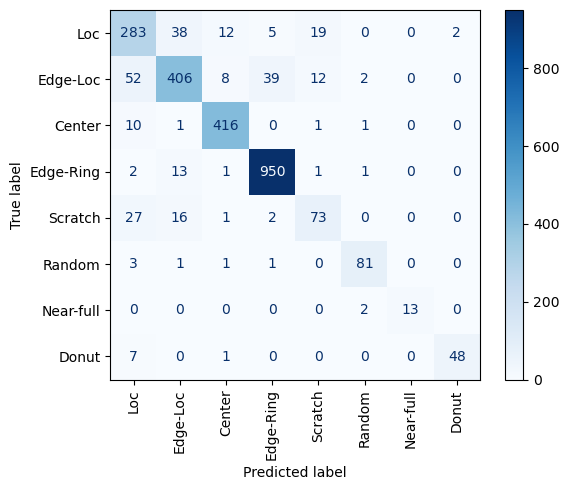

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 参考：https://qiita.com/wakame1367/items/5420ac91702edf993124
print(accuracies)
labels = df['failureType'].unique()
cm = confusion_matrix(y_pred=user_result_df['failureType'], y_true=y_test_df['failureType'], labels=labels)
# display_labels: 集計して表示するラベル。
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)

cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
